### Installing required libs

In [1]:
! pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Importing Important Libraries

In [42]:
from google.colab import drive
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split, Dataset
import PIL
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary

In [43]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
! unzip -qq '/content/drive/MyDrive/datasets/train.zip'

In [45]:
#! mkdir '/content/datasets_mask'

In [46]:
#! mv /content/train/with_mask/* /content/datasets_mask/

In [47]:
#! mv /content/train/without_mask/* /content/datasets_mask/

### Data Collection and Preprocessing

In [48]:
class ImageData(Dataset):
  def __init__(self, img_path, img_labels, trans=None):
    self.img_path = img_path
    self.img_labels = torch.Tensor(img_labels)
    if trans is None:
      self.transforms = transforms.ToTensor()
    else:
      self.transforms = trans

  def __getitem__(self, index):
    curr_path = self.img_path[index]
    curr_img = PIL.Image.open(curr_path)
    curr_img = self.transforms(curr_img)

    return curr_img, self.img_labels[index]

  def __len__(self):
    return len(self.img_path)

In [65]:
mask_img_lists = glob.glob(os.path.join('/content/train/with_mask', '*'))
nomask_img_lists = glob.glob(os.path.join('/content/train/without_mask', '*'))

print(len(mask_img_lists))
print(len(nomask_img_lists))

658
656


In [66]:
mask_labels = [0] * len(mask_img_lists)
nomask_labels = [1] * len(nomask_img_lists)
img_lists = mask_img_lists + nomask_img_lists
labels = mask_labels + nomask_labels

print(len(img_lists))
print(len(labels))

1314
1314


In [64]:
#labels = [0 if img_path.split('/')[3][0] == 'M' else 1 for img_path in img_lists]

In [67]:
transformations = transforms.Compose([transforms.Lambda(lambda x: x.convert('RGB') if x.mode != 'RGB' else x),
                                      transforms.Resize((150, 150)),  # resize to input shape of our CNN
                                      #transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
                                      transforms.RandomRotation(40),
                                      #transforms.RandomAffine(degrees=0, scale=(0.8, 1.2), shear=0.2),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor()  # convert PIL to Tensor
                                      ])

In [68]:
mask_data = ImageData(img_lists, labels, trans=transformations)

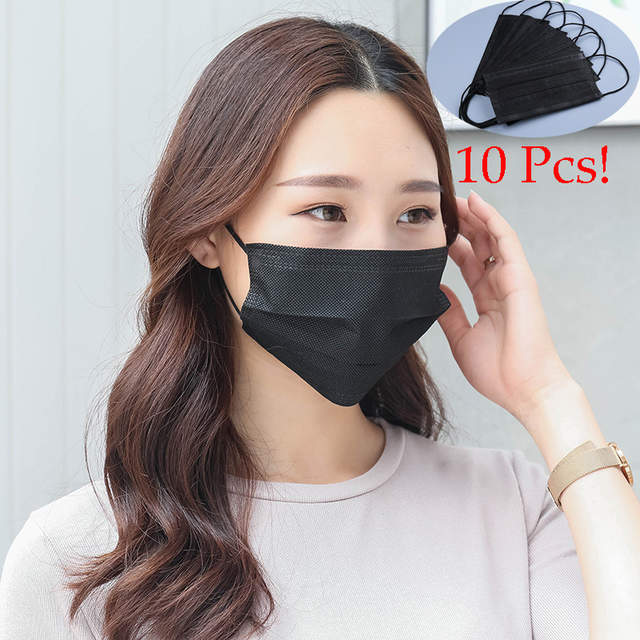

In [72]:
# get a sample image
sample_img_path = os.path.join('/content/train/with_mask/', os.listdir('/content/train/with_mask/')[103])
sample_img = PIL.Image.open(sample_img_path)
display(sample_img)

(-0.5, 149.5, 149.5, -0.5)

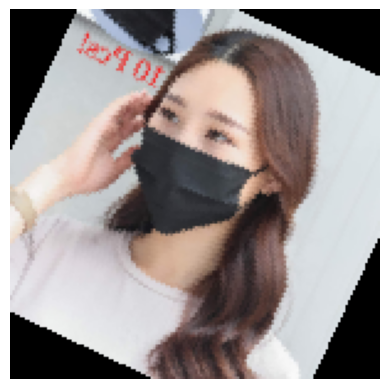

In [74]:
image = mask_data[103][0].cpu().numpy()
image = np.transpose(image, (1, 2, 0))
plt.imshow(image)
plt.axis('off')

In [75]:
mask_data[103][1]

tensor(0.)

In [77]:
mask_data[103][0].size()

torch.Size([3, 150, 150])

### Split Dataset

In [88]:
split_size = (np.array([0.7, 0.2, 0.1]) * len(mask_data)).round().astype(np.int)

<ipython-input-88-da097bf3a82a>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  split_size = (np.array([0.7, 0.2, 0.1]) * len(mask_data)).round().astype(np.int)


In [89]:
train_data, eval_data, test_data = random_split(mask_data, split_size)

In [90]:
len(train_data)

920

### Model Implementation

In [91]:
class MaskNoMaskClassifier(nn.Module):
  def __init__(self):
    super(MaskNoMaskClassifier, self).__init__()

    self.sequential = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3), # (32, 148, 148)
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2), # (32, 74, 74),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3), # (64, 72, 72)
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2), # (64, 36, 36)
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3), # (128, 34, 34)
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2), # (128, 17, 17)
        nn.Flatten(), # 36992
    )

    self.classifier = nn.Sequential(
        nn.Linear(in_features=36992, out_features=512),
        nn.ReLU(),
        # nn.Linear(in_features=1024, out_features=512),
        # nn.ReLU(),
        nn.Linear(in_features=512, out_features=1)
    )

  def forward(self, features):
    features = self.sequential(features)
    features = self.classifier(features)

    return features

In [92]:
model = MaskNoMaskClassifier()
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [93]:
summary(model, (15, 3, 150, 150))

Layer (type:depth-idx)                   Output Shape              Param #
MaskNoMaskClassifier                     [15, 1]                   --
├─Sequential: 1-1                        [15, 36992]               --
│    └─Conv2d: 2-1                       [15, 32, 148, 148]        896
│    └─ReLU: 2-2                         [15, 32, 148, 148]        --
│    └─MaxPool2d: 2-3                    [15, 32, 74, 74]          --
│    └─Conv2d: 2-4                       [15, 64, 72, 72]          18,496
│    └─ReLU: 2-5                         [15, 64, 72, 72]          --
│    └─MaxPool2d: 2-6                    [15, 64, 36, 36]          --
│    └─Conv2d: 2-7                       [15, 128, 34, 34]         73,856
│    └─ReLU: 2-8                         [15, 128, 34, 34]         --
│    └─MaxPool2d: 2-9                    [15, 128, 17, 17]         --
│    └─Flatten: 2-10                     [15, 36992]               --
├─Sequential: 1-2                        [15, 1]                   --
│    └

### Training 

In [94]:
def train_model(model, train_data, test_data, device, optimizer, epochs=50, batch_size=64):

  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

  model = model.to(device)

  history = {'train_loss': [],
             'train_acc': [],
             'test_loss':[],
             'test_acc':[]}
  loss_fn = nn.BCEWithLogitsLoss()
  optimizer = optimizer

  print('Training Starts')

  for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    test_loss = 0.0
    test_acc = 0.0

    for x, y in train_loader:
      #print(x.size())
      x = x.to(device)
      y = y.to(device)

      # forward prop
      outputs = model(x).view(-1)
      predictions = torch.sigmoid(outputs)
      predictions = torch.round(predictions)
      loss = loss_fn(outputs, y)
      curr_train_acc = (predictions == y).sum().item() / batch_size
      
      # backward
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      # loss and accuracy
      train_loss += loss
      train_acc += curr_train_acc

    
    # testing
    model.eval()
    with torch.no_grad():
      for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        outputs = model(x).view(-1)
        predictions = torch.sigmoid(outputs)
        predictions = torch.round(predictions)

        loss = loss_fn(outputs, y)
        curr_test_acc = (predictions == y).sum().item() / batch_size

        test_loss += loss
        test_acc += curr_test_acc

      train_loss = (train_loss/len(train_loader)).item()
      test_loss = (test_loss/len(test_loader)).item()
      train_acc = train_acc / len(train_loader)
      test_acc = test_acc / len(test_loader)

      history['train_loss'].append(train_loss)
      history['train_acc'].append(train_acc)
      history['test_loss'].append(test_loss)
      history['test_acc'].append(test_acc)

      print(f"Epoch: {epoch + 1} / {epochs}, train loss:{train_loss:.4f}, train accuracy:{train_acc:.4f}, eval loss: {test_loss:.4f}, eval accuracy:{test_acc:.4f}")

  return history

In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(),  lr=0.001)
epochs = 30
batch_size = 32

In [103]:
history = train_model(model=model, train_data=train_data, test_data=eval_data, device=device, optimizer=optimizer, epochs=epochs, batch_size=batch_size)

Training Starts
Epoch: 1 / 30, train loss:0.4333, train accuracy:0.7845, eval loss: 0.1989, eval accuracy:0.8646
Epoch: 2 / 30, train loss:0.1703, train accuracy:0.9375, eval loss: 0.1168, eval accuracy:0.8924
Epoch: 3 / 30, train loss:0.1339, train accuracy:0.9483, eval loss: 0.0615, eval accuracy:0.8889
Epoch: 4 / 30, train loss:0.1425, train accuracy:0.9472, eval loss: 0.0899, eval accuracy:0.8889
Epoch: 5 / 30, train loss:0.0953, train accuracy:0.9569, eval loss: 0.0518, eval accuracy:0.8924
Epoch: 6 / 30, train loss:0.0787, train accuracy:0.9612, eval loss: 0.0612, eval accuracy:0.8889
Epoch: 7 / 30, train loss:0.0756, train accuracy:0.9634, eval loss: 0.0531, eval accuracy:0.8993
Epoch: 8 / 30, train loss:0.0691, train accuracy:0.9634, eval loss: 0.0507, eval accuracy:0.8924
Epoch: 9 / 30, train loss:0.0668, train accuracy:0.9731, eval loss: 0.0650, eval accuracy:0.8785
Epoch: 10 / 30, train loss:0.0700, train accuracy:0.9634, eval loss: 0.0772, eval accuracy:0.8715
Epoch: 11 / 3